In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CSV_PATH = "AQI Bangladesh.csv"  
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (1048551, 13)
Columns: ['city_id', 'city_name', 'lat', 'lon', 'datetime', 'pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'aqi']


In [3]:
# Parse datetime
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Basic sanity
print("\nDatetime nulls:", df["datetime"].isna().sum())
print("Unique cities:", df["city_name"].nunique())


Datetime nulls: 0
Unique cities: 30


In [4]:
pollutant_cols = [
    "pm2_5", "pm10",
    "carbon_monoxide", "carbon_dioxide",
    "nitrogen_dioxide", "sulphur_dioxide",
    "ozone", "aqi"
]
pollutant_cols = [c for c in pollutant_cols if c in df.columns]
print("\nUsing pollutant columns:", pollutant_cols)

# Month key
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["ym"] = df["datetime"].dt.to_period("M").astype(str)


Using pollutant columns: ['pm2_5', 'pm10', 'carbon_monoxide', 'carbon_dioxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'aqi']


In [5]:
# 1A) Missing rate per city-month
g = df.groupby(["city_name", "ym"], observed=True)

counts = g.size().rename("n_rows")

miss_counts = g[pollutant_cols].apply(lambda x: x.isna().sum())
miss_counts.columns = [f"miss_{c}" for c in miss_counts.columns]

miss_rate = g[pollutant_cols].apply(lambda x: x.isna().mean())
miss_rate.columns = [f"missrate_{c}" for c in miss_rate.columns]

monthly_missing = pd.concat([counts, miss_counts, miss_rate], axis=1).reset_index()

print(monthly_missing.head())
monthly_missing.to_csv("city_month_missing_summary.csv", index=False)
print("\nSaved: city_month_missing_summary.csv")

  city_name       ym  n_rows  miss_pm2_5  miss_pm10  miss_carbon_monoxide  \
0   Azimpur  2022-08     648           0          0                     0   
1   Azimpur  2022-09     720           0          0                     0   
2   Azimpur  2022-10     744           0          0                     0   
3   Azimpur  2022-11     720           0          0                     0   
4   Azimpur  2022-12     744           0          0                     0   

   miss_carbon_dioxide  miss_nitrogen_dioxide  miss_sulphur_dioxide  \
0                  648                      0                     0   
1                  720                      0                     0   
2                  744                      0                     0   
3                  720                      0                     0   
4                  744                      0                     0   

   miss_ozone  miss_aqi  missrate_pm2_5  missrate_pm10  \
0           0         0             0.0            0

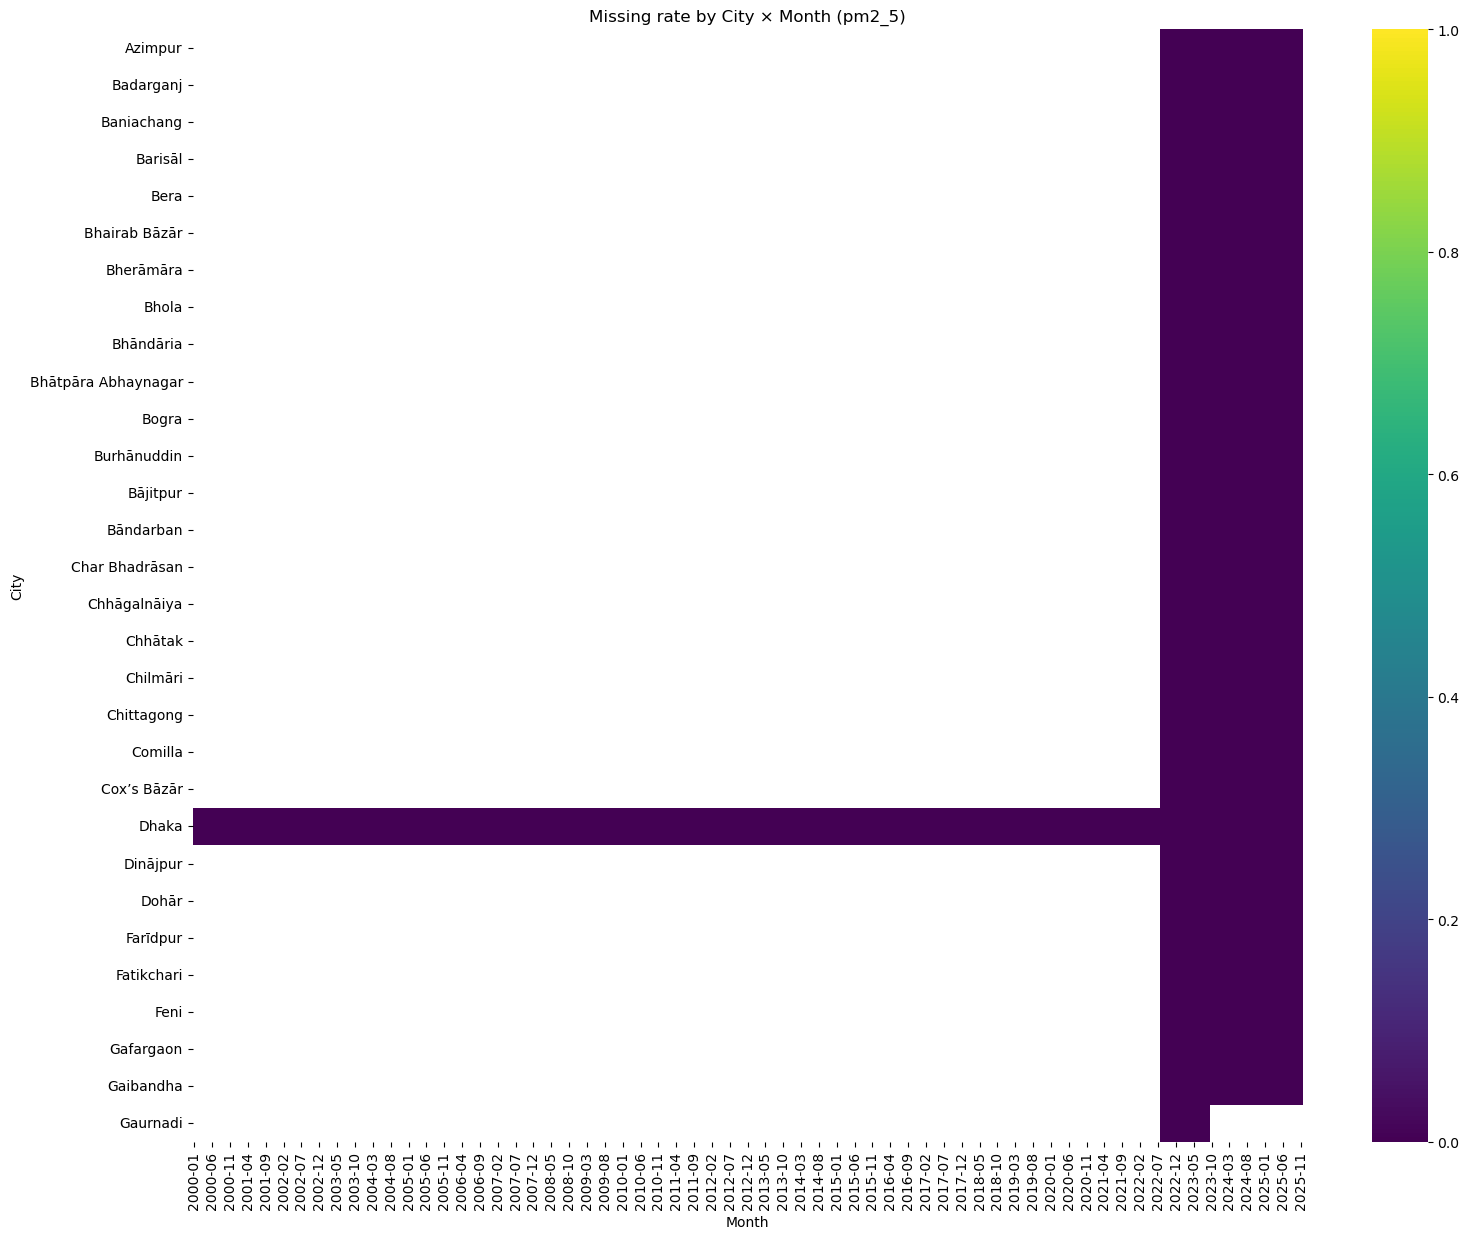

In [6]:
# 1C) Heatmap of missing rate for a chosen variable
var = "pm2_5"
key = f"missrate_{var}"
if key in monthly_missing.columns:
    piv = monthly_missing.pivot(index="city_name", columns="ym", values=key).sort_index()
    plt.figure(figsize=(16, 0.35 * len(piv.index) + 2))
    sns.heatmap(piv, cmap="viridis", vmin=0, vmax=1)
    plt.title(f"Missing rate by City × Month ({var})")
    plt.xlabel("Month")
    plt.ylabel("City")
    plt.tight_layout()
    plt.show()
else:
    print(f"Missing rate column {key} not found.")


In [7]:
# 2) Overlapping time window across all cities (per variable)
def city_time_ranges_for_var(df, var, city_col="city_name", time_col="datetime"):
    tmp = df.loc[df[time_col].notna() & df[var].notna(), [city_col, time_col]].copy()
    out = tmp.groupby(city_col)[time_col].agg(["min", "max", "count"]).reset_index()
    out = out.sort_values(city_col)
    return out

def overlap_window(ranges_df):
    # ranges_df has columns: min, max
    latest_start = ranges_df["min"].max()
    earliest_end = ranges_df["max"].min()
    ok = pd.notna(latest_start) and pd.notna(earliest_end) and (latest_start <= earliest_end)
    return ok, latest_start, earliest_end

for var in ["pm2_5", "pm10", "aqi"]:
    if var not in df.columns: 
        continue
    r = city_time_ranges_for_var(df, var)
    ok, s, e = overlap_window(r)
    print(f"\n=== {var} ===")
    print(r.head())
    print("Overlap across ALL cities:", ok)
    print("Latest city-start:", s)
    print("Earliest city-end:", e)

    r.to_csv(f"city_time_ranges_{var}.csv", index=False)
    print(f"Saved: city_time_ranges_{var}.csv")



=== pm2_5 ===
    city_name        min                 max  count
0     Azimpur 2022-08-05 2025-11-23 23:00:00  28968
1   Badarganj 2022-08-04 2025-11-23 23:00:00  28992
2  Baniachang 2022-08-04 2025-11-23 23:00:00  28992
3     Barisāl 2022-08-04 2025-11-23 23:00:00  28992
4        Bera 2022-08-04 2025-11-23 23:00:00  28992
Overlap across ALL cities: True
Latest city-start: 2022-08-05 00:00:00
Earliest city-end: 2023-09-15 14:00:00
Saved: city_time_ranges_pm2_5.csv

=== pm10 ===
    city_name        min                 max  count
0     Azimpur 2022-08-05 2025-11-23 23:00:00  28968
1   Badarganj 2022-08-04 2025-11-23 23:00:00  28992
2  Baniachang 2022-08-04 2025-11-23 23:00:00  28992
3     Barisāl 2022-08-04 2025-11-23 23:00:00  28992
4        Bera 2022-08-04 2025-11-23 23:00:00  28992
Overlap across ALL cities: True
Latest city-start: 2022-08-05 00:00:00
Earliest city-end: 2023-09-15 14:00:00
Saved: city_time_ranges_pm10.csv

=== aqi ===
    city_name        min                 max  c

In [8]:
# 2B) Overlap window requiring ALL pollutant_cols non-missing
mask_all = df["datetime"].notna()
for c in pollutant_cols:
    mask_all &= df[c].notna()

tmp = df.loc[mask_all, ["city_name", "datetime"]].copy()
ranges_all = tmp.groupby("city_name")["datetime"].agg(["min", "max", "count"]).reset_index()
ok, s, e = overlap_window(ranges_all)

print("\n=== All pollutants present ===")
print(ranges_all.sort_values("count").head(10))
print("Overlap across ALL cities:", ok)
print("Latest city-start:", s)
print("Earliest city-end:", e)

ranges_all.to_csv("city_time_ranges_all_pollutants_present.csv", index=False)
print("Saved: city_time_ranges_all_pollutants_present.csv")



=== All pollutants present ===
      city_name        min                 max  count
0       Azimpur 2024-10-26 2025-11-23 23:00:00   9456
26         Feni 2024-10-26 2025-11-23 23:00:00   9456
25   Fatikchari 2024-10-26 2025-11-23 23:00:00   9456
24     Farīdpur 2024-10-26 2025-11-23 23:00:00   9456
23        Dohār 2024-10-26 2025-11-23 23:00:00   9456
22     Dinājpur 2024-10-26 2025-11-23 23:00:00   9456
21        Dhaka 2024-10-26 2025-11-23 23:00:00   9456
20  Cox’s Bāzār 2024-10-26 2025-11-23 23:00:00   9456
19      Comilla 2024-10-26 2025-11-23 23:00:00   9456
18   Chittagong 2024-10-26 2025-11-23 23:00:00   9456
Overlap across ALL cities: True
Latest city-start: 2024-10-26 00:00:00
Earliest city-end: 2025-11-23 23:00:00
Saved: city_time_ranges_all_pollutants_present.csv


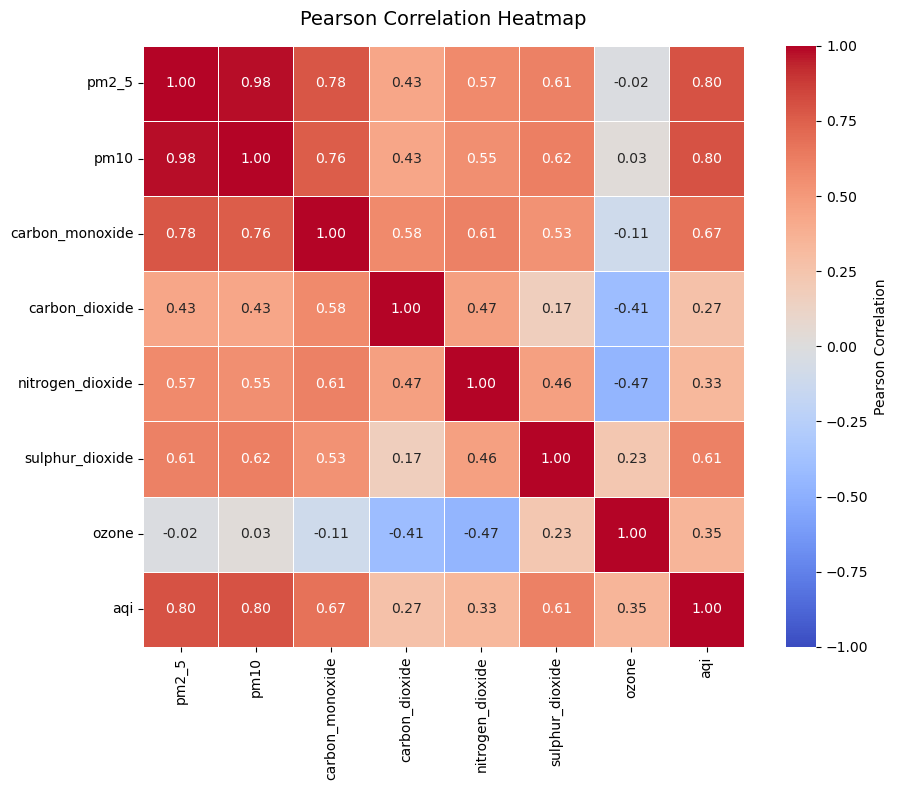

In [12]:
# Pearson correlation heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson,
    annot=True,           # Show numbers inside cells
    fmt=".2f",            # Format numbers to 2 decimal places
    cmap="coolwarm",      # Basic diverging RGB colormap (blue-white-red)
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation"}
)
plt.title("Pearson Correlation Heatmap", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import geopandas as gpd

In [13]:
# Drop the main culprit city (coverage constraint)
df = df[df["city_name"] != "Gaurnadi"].copy()

# Variables for the "chemistry regime" fingerprint:
target = "pm2_5"
finger_cols = ["pm10", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone", "aqi"]
use_cols = [target] + finger_cols

In [14]:
# Recommended paper window: 2023–2025 (clean and long)
start = pd.Timestamp("2023-01-01 00:00:00")
end   = pd.Timestamp("2025-11-23 23:00:00")  # your dataset max for most cities

dfw = df[(df["datetime"] >= start) & (df["datetime"] <= end)].copy()

# Ensure we only correlate on rows where these are present
dfw = dfw.dropna(subset=use_cols)

print("Window rows:", len(dfw))
print("Cities in window:", dfw["city_name"].nunique())

Window rows: 736368
Cities in window: 29


In [15]:
rows = []
for city, g in dfw.groupby("city_name", observed=True):
    # Spearman correlations for target against others
    C = g[use_cols].corr(method="spearman")
    fp = C.loc[target, finger_cols]
    rows.append([city] + fp.values.tolist() + [len(g)])

fp_df = pd.DataFrame(rows, columns=["city_name"] + [f"rho_{c}" for c in finger_cols] + ["n"])
# Handle any weird NaNs (should be rare): fill with column means
rho_cols = [c for c in fp_df.columns if c.startswith("rho_")]
fp_df[rho_cols] = fp_df[rho_cols].apply(lambda s: s.fillna(s.mean()))

print(fp_df.head())

    city_name  rho_pm10  rho_carbon_monoxide  rho_nitrogen_dioxide  \
0     Azimpur  0.975160             0.879535              0.659751   
1   Badarganj  0.965400             0.807548              0.432194   
2  Baniachang  0.974188             0.846840              0.404649   
3     Barisāl  0.977617             0.908621              0.574051   
4        Bera  0.966506             0.874340              0.378109   

   rho_sulphur_dioxide  rho_ozone   rho_aqi      n  
0             0.697288  -0.074267  0.892672  25392  
1             0.682663  -0.076979  0.811421  25392  
2             0.718870   0.205477  0.886580  25392  
3             0.842159   0.330529  0.917409  25392  
4             0.676027   0.152253  0.868842  25392  


In [19]:
X = fp_df[rho_cols].values
Xz = StandardScaler().fit_transform(X)

k_candidates = list(range(2, 9))
scores = []

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(Xz)
    score = silhouette_score(Xz, labels)
    scores.append(score)

best_k = k_candidates[int(np.argmax(scores))]
print("Silhouette scores:", dict(zip(k_candidates, scores)))
print("Best k:", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=50)
fp_df["cluster"] = km.fit_predict(Xz)

# Save results
fp_df.to_csv("city_corr_fingerprints_clusters.csv", index=False)
print("Saved: city_corr_fingerprints_clusters.csv")

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Silhouette scores: {2: 0.3485234263078791, 3: 0.30341457699918917, 4: 0.3125122061935128, 5: 0.31580201373207456, 6: 0.3535939598471414, 7: 0.3791598751147093, 8: 0.3788979859212896}
Best k: 7
Saved: city_corr_fingerprints_clusters.csv


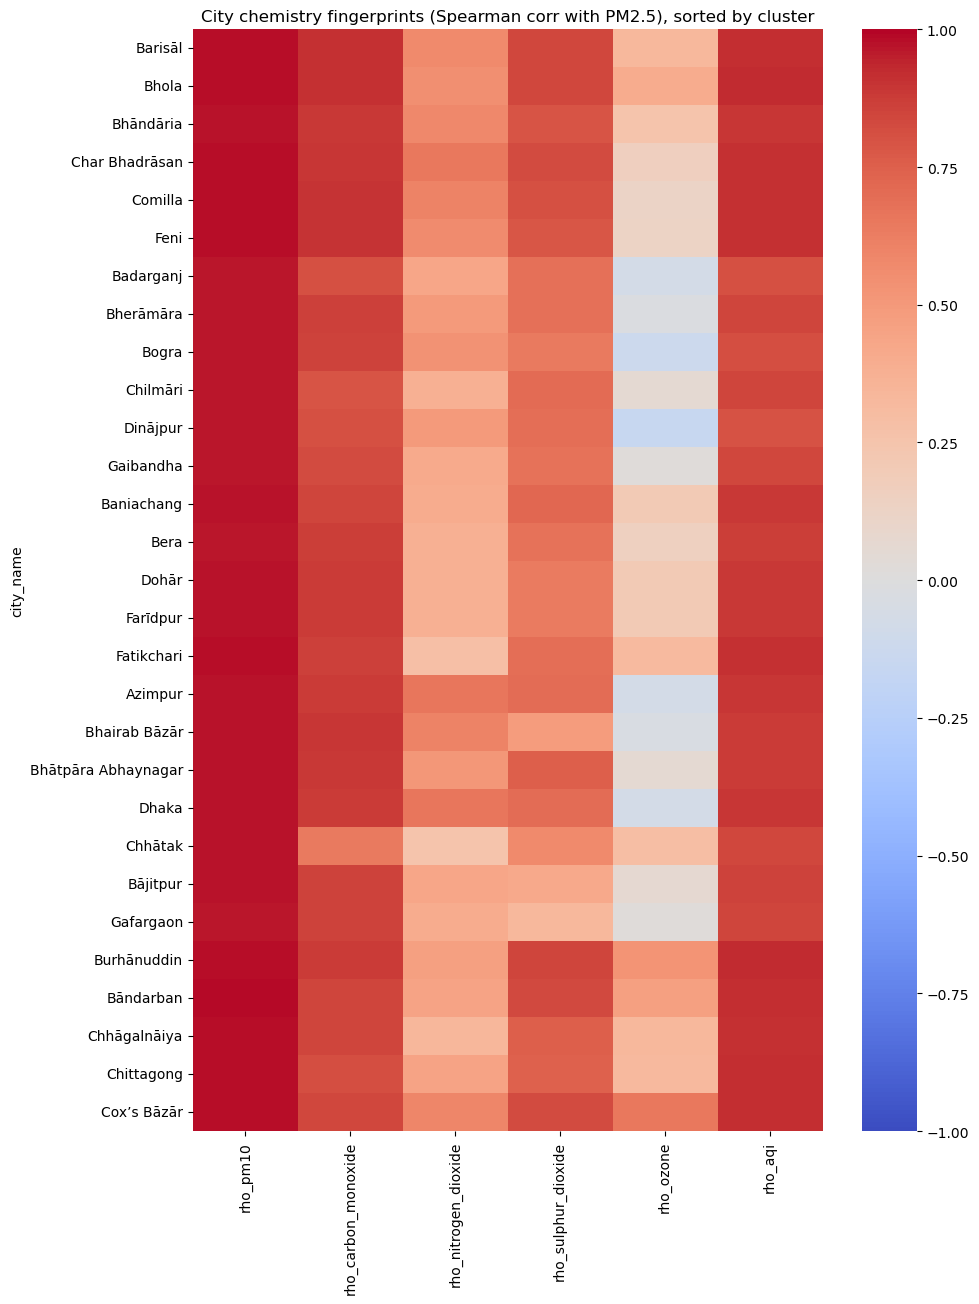

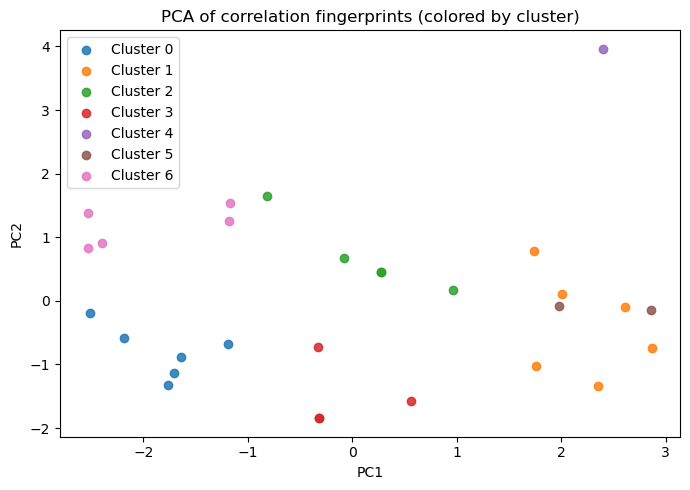

In [22]:
# 5A) Heatmap of fingerprints, sorted by cluster
fp_sorted = fp_df.sort_values(["cluster", "city_name"]).set_index("city_name")
plt.figure(figsize=(10, 0.35 * len(fp_sorted) + 3))
sns.heatmap(fp_sorted[rho_cols], cmap="coolwarm", vmin=-1, vmax=1)
plt.title("City chemistry fingerprints (Spearman corr with PM2.5), sorted by cluster")
plt.tight_layout()
plt.show()

# 5B) 2D PCA scatter (nice cluster visualization)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xz)

plt.figure(figsize=(7, 5))
for cl in sorted(fp_df["cluster"].unique()):
    m = fp_df["cluster"] == cl
    plt.scatter(Z[m, 0], Z[m, 1], label=f"Cluster {cl}", alpha=0.85)

plt.title("PCA of correlation fingerprints (colored by cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

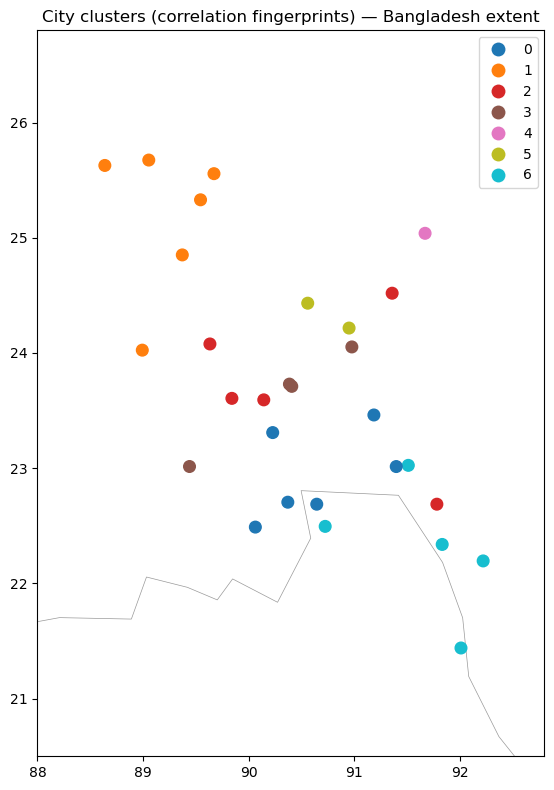

In [27]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

# ---- 1) Load any Natural Earth "land" dataset (geodatasets name varies)
def get_ne_land_gdf():
    candidates = [
        "naturalearth.land",
        "naturalearth land",
        "naturalearth_land",
        "naturalearth physical land",
        "naturalearth.physical_land",
    ]
    last_err = None
    for name in candidates:
        try:
            path = geodatasets.get_path(name)
            return gpd.read_file(path).to_crs("EPSG:4326")
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not find a Natural Earth land dataset in geodatasets. Last error: {last_err}")

land = get_ne_land_gdf()

# ---- 2) City coordinates (median per city)
# expects dfw has columns city_name, lat, lon
city_geo = (dfw.groupby("city_name")[["lat", "lon"]]
            .median()
            .reset_index())

out = fp_df.merge(city_geo, on="city_name", how="left")

gdf_points = gpd.GeoDataFrame(
    out,
    geometry=gpd.points_from_xy(out["lon"], out["lat"]),
    crs="EPSG:4326"
)

# ---- 3) Plot background + points
ax = land.plot(figsize=(7, 8), edgecolor="0.6", facecolor="white", linewidth=0.5)

# Bangladesh approx bounding box (EPSG:4326)
# lon: 88.0–92.8, lat: 20.5–26.8 (safe padding)
ax.set_xlim(88.0, 92.8)
ax.set_ylim(20.5, 26.8)

gdf_points.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    legend=True,
    markersize=70
)

plt.title("City clusters (correlation fingerprints) — Bangladesh extent")
plt.tight_layout()
plt.show()
